
# Dynamic Factor Model (DFM) con VIX y MOVE (riesgo latente de mercado)

In [1]:
# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from statsmodels.tsa.statespace.structural import UnobservedComponents

plt.rcParams["figure.figsize"] = (10, 4)



## 1) Datos

In [2]:
import pandas as pd
import yfinance as yf

def fetch_yahoo_index(ticker: str, start="1990-01-01", end=None) -> pd.Series:
    df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False)
    if df.empty:
        raise ValueError(f"No data returned for {ticker}")

    # pick close column name that exists at top level
    if isinstance(df.columns, pd.MultiIndex):
        lvl0 = df.columns.get_level_values(0)
        price_col = "Adj Close" if "Adj Close" in lvl0 else "Close"
        px = df[price_col]  # usually a DataFrame with columns = tickers
        if isinstance(px, pd.DataFrame):
            px = px[ticker] if ticker in px.columns else px.iloc[:, 0]
    else:
        price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
        px = df[price_col]  # Series

    px = px.dropna()
    px.name = ticker
    return px

move = fetch_yahoo_index("^MOVE", start="2000-01-01")
vix  = fetch_yahoo_index("^VIX",  start="1990-01-01")

iv = pd.concat([move, vix], axis=1).sort_index()
print(iv.tail())

                ^MOVE       ^VIX
Date                            
2026-02-13  70.099998  20.600000
2026-02-17  68.839996  20.290001
2026-02-18  64.190002  19.620001
2026-02-19  68.029999  20.230000
2026-02-20  64.269997  19.090000


In [3]:
df = iv.rename(columns={"^MOVE": "MOVE", "^VIX": "VIX"})

In [5]:
import plotly.graph_objects as go

fig = go.Figure()

for col in ["VIX", "MOVE"]:
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[col],
            mode="lines",
            name=col,
        )
    )

fig.update_layout(
    title="Series originales (niveles)",
    xaxis_title="Fecha",
    yaxis_title="Nivel",
    legend_title_text="Serie",
    template="plotly_white",
)

fig.show()


## 2) Transformaciones 

Para DFM con volatilidades implícitas, suele ser estable usar:
- $\log(\text{VIX})$, $\log(\text{MOVE})$
- y estandarizar (z-score) para que estén en escalas comparables.

Definimos:
$$
x_t = \begin{pmatrix} z(\log VIX_t) \\ z(\log MOVE_t) \end{pmatrix}
$$


In [6]:
# 2) Log + estandarización
X = np.log(df[["VIX", "MOVE"]]).copy()
X = (X - X.mean()) / X.std()  # z-scores

X.head()


,VIX,MOVE
Date,,
1990-01-02,-0.167750,NaN
1990-01-03,-0.010801,NaN
1990-01-04,0.150360,NaN
1990-01-05,0.282807,NaN
1990-01-08,0.304551,NaN


In [7]:
X = X.dropna()
X

,VIX,MOVE
Date,,
2002-11-12,1.509169,1.136079
2002-11-13,1.571648,1.202030
2002-11-14,1.320458,1.377817
2002-11-15,1.106680,1.424913
2002-11-18,1.215521,1.351202
...,...,...
2026-02-13,0.353247,-0.483019
2026-02-17,0.308880,-0.537471
2026-02-18,0.210630,-0.747432


In [8]:
X = X.copy().sort_index()
X.index = pd.to_datetime(X.index)
X = X[~X.index.duplicated(keep="first")]
X = X.asfreq("B")               # o la frecuencia correcta
# Decide UNA:
X = X.dropna()                # overlap estricto
# X = X.ffill()                 # panel completo imputado (ojo con sesgos)

In [9]:
Xz = (X - X.mean()) / X.std(ddof=0)
Xz = Xz.asfreq("B")


## 3) DFM con 1 factor (k=1) y dinámica AR(1) del factor

Modelo:

**Medición**
$$
x_t = \Lambda f_t + \varepsilon_t
$$

**Dinámica del factor**
$$
f_t = \phi f_{t-1} + u_t
$$

En `statsmodels`, esto se especifica como:
- `k_factors=1`
- `factor_order=1` (AR(1) para el factor)

El modelo estima:
- Cargas $\Lambda$ (sensibilidad de cada serie al factor).
- La trayectoria $f_t$ (filtrada y suavizada).


In [10]:
mod = DynamicFactor(Xz, k_factors=1, factor_order=2, error_order=1)
res = mod.fit(maxiter=2000, disp=False)

In [11]:
print(res.summary())

                                   Statespace Model Results                                  
Dep. Variable:                       ['VIX', 'MOVE']   No. Observations:                 6074
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood                2969.996
                                      + AR(1) errors   AIC                          -5923.992
Date:                               Sat, 21 Feb 2026   BIC                          -5870.298
Time:                                       23:00:31   HQIC                         -5905.357
Sample:                                   11-12-2002                                         
                                        - 02-20-2026                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):          1023.12, 3.14   Jarque-Bera (JB):    12348.41, 7323.66
Prob(Q):                        0.00, 0.08   Prob(JB):                


## 4) Interpretación de $\Lambda$ (cargas)

En un DFM de 1 factor, $\Lambda$ es un vector con 2 entradas:
- $\lambda_{VIX}$: cuánto responde el VIX (transformado y estandarizado) al factor común.
- $\lambda_{MOVE}$: cuánto responde MOVE al factor común.

**Importante (identificación de signo):** el factor está definido hasta un signo. Si sale “invertido”, puedes multiplicar $f_t$ por $-1$ para que “riesgo alto” corresponda a VIX y MOVE altos.


In [12]:
# 4) Extraer cargas (Lambda) y factor (f_t)
# En statsmodels, los 'loadings' aparecen en params con prefijos.
params = res.params
params


loading.f1.VIX        2.762409e-01
loading.f1.MOVE       4.949466e-02
sigma2.VIX            4.078338e-11
sigma2.MOVE           1.477808e-02
L1.f1.f1              1.216821e-04
L2.f1.f1              9.998765e-01
L1.e(VIX).e(VIX)     -9.271580e-01
L1.e(MOVE).e(MOVE)    9.912314e-01
dtype: float64

In [13]:


def factor_a_serie(factors_obj, which: str, index, k: int = 0) -> pd.Series:
    """
    Convierte res.factors.{filtered,smoothed} en pd.Series.
    Soporta outputs como DataFrame o ndarray con forma (T,k) o (k,T).
    """
    arr = getattr(factors_obj, which)

    # Caso 1: ya es DataFrame
    if isinstance(arr, pd.DataFrame):
        s = arr.iloc[:, k].copy()
        s.index = index
        s.name = f"factor_{k+1}_{which}"
        return s

    # Caso 2: ndarray
    arr = np.asarray(arr)
    T = len(index)

    if arr.ndim == 1:
        if arr.shape[0] != T:
            raise ValueError(f"Dimensión inesperada {arr.shape}; esperado largo T={T}.")
        return pd.Series(arr, index=index, name=f"factor_{k+1}_{which}")

    if arr.ndim != 2:
        raise ValueError(f"Dimensión inesperada {arr.ndim}; esperado 1 o 2.")

    # (T,k) vs (k,T)
    if arr.shape[0] == T:
        vec = arr[:, k]
    elif arr.shape[1] == T:
        vec = arr[k, :]
    else:
        raise ValueError(f"Forma inesperada {arr.shape}; no cuadra con T={T}.")

    return pd.Series(vec, index=index, name=f"factor_{k+1}_{which}")

# 4.1) Extraer series del factor: filtrado y suavizado
f_filt   = factor_a_serie(res.factors, "filtered", Xz.index, k=0)
f_smooth = factor_a_serie(res.factors, "smoothed", Xz.index, k=0)

In [14]:
s = f_smooth.rename("factor").to_frame().join(X[["VIX"]], how="inner").dropna()
rho = s["factor"].corr(s["VIX"])  # Pearson por defecto

if rho < 0:
    f_filt = -f_filt
    f_smooth = -f_smooth


In [15]:
df = (
    f_filt.rename("factor").to_frame()
    .join(X[["VIX", "MOVE"]], how="inner")
    .dropna()
)

corr_vix  = df["factor"].corr(df["VIX"])
corr_move = df["factor"].corr(df["MOVE"])

print(f"Corr(factor, VIX)  = {corr_vix:.6f}")
print(f"Corr(factor, MOVE) = {corr_move:.6f}")


Corr(factor, VIX)  = 1.000000
Corr(factor, MOVE) = 0.540775


In [16]:

fig = go.Figure(
    data=[
        go.Scatter(
            x=f_filt.index,
            y=f_filt.values,
            mode="lines",
            name="f_t",
        )
    ]
)

fig.update_layout(
    title="Factor latente: índice de riesgo común",
    xaxis_title="Fecha",
    yaxis_title="f_t (escala arbitraria)",
    template="plotly_white",
)

fig.show()

## 5) Tendencia ultimo medio ciclo

In [17]:

import numpy as np
import matplotlib.pyplot as plt

from trend import train_val_test_split, GuerreroTrendEstimator
from trend.plotting import plot_scan, plot_train_val_test_fit


In [37]:
Z = f_filt[-int(252*3.5):]

In [45]:
Z_train, Z_val, Z_test, split = train_val_test_split(Z, frac_train=0.8, frac_val=0.1, min_train=200, min_val=150)

In [46]:

d = 2
est = GuerreroTrendEstimator(d=d, n_train=split.n_train)
scan = est.scan_local_minima(Z_train, Z_val, n_grid=400)

len(scan.minima), scan.minima[:5]


(3,
 [MinimaPoint(s_unit=0.5963975008067816, val_mse=3.3288215916087167),
  MinimaPoint(s_unit=0.9606782585345516, val_mse=1.7175716909941097),
  MinimaPoint(s_unit=0.9881626247309773, val_mse=2.7207186857541283)])

AttributeError: 'MinimaScan' object has no attribute 's_minima'

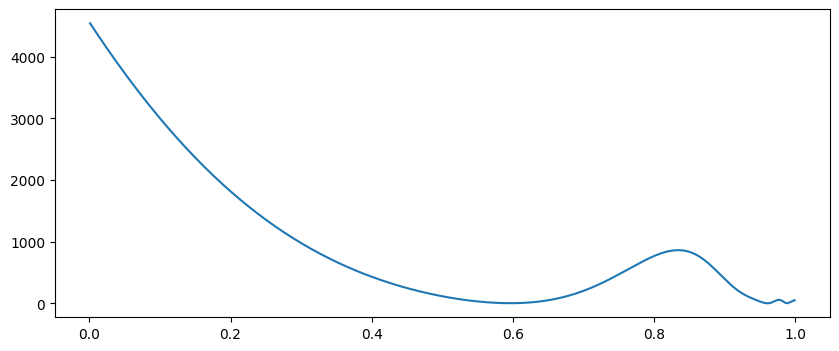

In [47]:

fig, ax = plt.subplots()
plot_scan(scan, title=f"Validation scan | d={d}", ax=ax)
plt.show()


In [48]:

best = scan.best()
best


MinimaPoint(s_unit=0.9606782585345516, val_mse=1.7175716909941097)

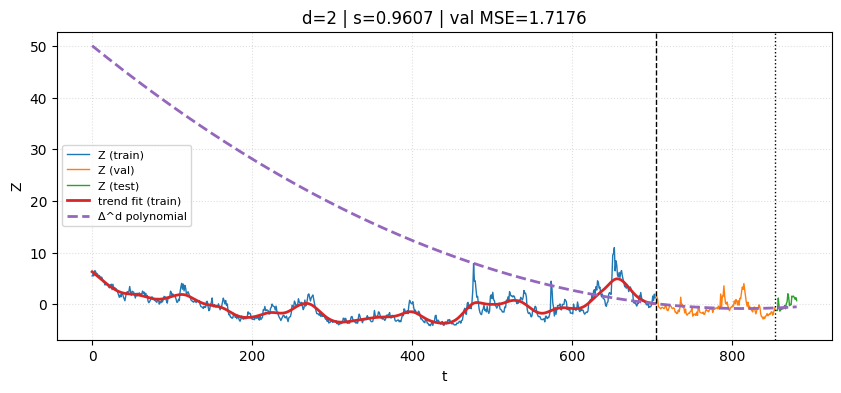

In [49]:

fit = est.fit_train(Z_train, s_unit=best.s_unit)
poly_full = est.build_polynomial_full(
    t_hat_train=fit.t_hat,
    m_hat=fit.m_hat,
    n_total=len(Z),
    n_train=split.n_train,
)

fig, ax = plt.subplots()
plot_train_val_test_fit(
    Z_all=Z,
    n_train=split.n_train,
    n_val=split.n_val,
    t_hat_train=fit.t_hat,
    poly_full=poly_full,
    label="Z",
    title=f"d={d} | s={best.s_unit:.4f} | val MSE={best.val_mse:.4f}",
    ax=ax,
)
plt.show()
